- day + animal + sex
- experiment + animal + sex
- comparison top 10 to rest in both


Expectations:
- variation across different experiments and gap lengths
- stronger in female mice
- variation across recording days without pattern
- stronger in first 10 recordings

Sex: nominal chi-squared
Weight: interval/ratio 
Strength: interval/ratio 
Reaction Time: interval/ratio 
Recording Day: nominal
Experiment type: nominal


reaction time non-parametric, strength normally distributed!


H0s:
1: no correlation between weight and strength if normalized -> extra weight does not indicate more muscle mass (no correlation, Pearson test)
2: no relationship between sex and strength (if strength normalized for weight? Maybe with and without normalization?) (independant two paired groups, ind. t-test and ANCOVA with weight as covariable) 
3: no influence of sex on reaction time (independant, Mann–Whitney U Test)
4: no relationship between day of measurement and strength and reaction time (ANOVA (norm, for strength), Friedman (non-para, for reaction time) OR linear mixed model)
5: first 10 recordings do not differ in strength or reaction time
6: experiment type has no influence on strength or reaction time


4th recording day would only help clarify effect of day

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare
import re
import seaborn as sns
import os
from itertools import combinations
import inspect
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

In [2]:
input_dir = "Results" # input directory

number = 6 # result number (subfolder name); 1: full results | 2: without gap duration and offset PPI | 3: also without peakTime and difference and with body weight normalization | 4: testing

In [3]:
results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

file_path = os.path.join(results_dir, files[0])
df = pd.read_excel(file_path)

file_path_top_10 = os.path.join(results_dir, files[1])
df_top_10 = pd.read_excel(file_path_top_10)

In [4]:
# Shapiro-Wilk test for normality

stat_strength, p_strength = shapiro(df["strength (g⋅kg^(-\u03B1))"].dropna())
print(f"Strength: W = {stat_strength:.3f}, p = {p_strength:.3g}")
# ----> normal


# Run Shapiro–Wilk test for reaction time
stat_rt, p_rt = shapiro(df["reactionTime (ms)"].dropna())
print(f"Reaction Time: W = {stat_rt:.3f}, p = {p_rt:.3g}")

# Try log fit
df["reactionTime_log"] = np.log(df["reactionTime (ms)"])
stat_rt_log, p_rt_log = shapiro(df["reactionTime_log"].dropna())
print(f"Log-transformed Reaction Time: p = {p_rt_log:.3g}")
# ----> nope

reaction_times = df["reactionTime (ms)"].dropna()

# Try Box-Cox transform
reaction_time_boxcox, fitted_lambda = boxcox(reaction_times)

# Store transformed values in the DataFrame (optional)
df["reactionTime_boxcox"] = pd.Series(reaction_time_boxcox, index=reaction_times.index)

# Test normality of Box-Cox transformed data
stat_boxcox, p_boxcox = shapiro(reaction_time_boxcox)
print(f"Box-Cox Transformed Reaction Time: W = {stat_boxcox:.3f}, p = {p_boxcox:.3g}")
print(f"Optimal λ = {fitted_lambda:.3f}")
# ----> nope

# -> reaction time non-parametric, strength normally distributed

""" # plot
sns.histplot(df["strength (g⋅kg^(-\u03B1))"].dropna(), kde=True)
plt.title("Histogram of Strength")
plt.show()

# Q-Q Plot
stats.probplot(df["strength (g⋅kg^(-\u03B1))"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Strength")
plt.show() """

Strength: W = 0.949, p = 0.0984
Reaction Time: W = 0.818, p = 3.7e-05
Log-transformed Reaction Time: p = 0.00147
Box-Cox Transformed Reaction Time: W = 0.929, p = 0.023
Optimal λ = -1.741


' # plot\nsns.histplot(df["strength (g⋅kg^(-α))"].dropna(), kde=True)\nplt.title("Histogram of Strength")\nplt.show()\n\n# Q-Q Plot\nstats.probplot(df["strength (g⋅kg^(-α))"].dropna(), dist="norm", plot=plt)\nplt.title("Q-Q Plot of Strength")\nplt.show() '

In [5]:
# compare top 10


t_stat, p_val = ttest_ind(df_top_10["strength (g⋅kg^(-\u03B1))"].dropna(),
                        df["strength (g⋅kg^(-\u03B1))"].dropna(),
                        equal_var=False)  # Welch’s t-test if variances unequal
print(f"T-test for strength: t = {t_stat:.3f}, p = {p_val:.3g}")
# ----> nope


u_stat, p_val = mannwhitneyu(df_top_10["reactionTime (ms)"].dropna(),
                            df["reactionTime (ms)"].dropna(),
                            alternative='two-sided')
print(f"Mann-Whitney U test for reaction time: U = {u_stat}, p = {p_val:.3g}")
# ----> nope

T-test for strength: t = 0.393, p = 0.696
Mann-Whitney U test for reaction time: U = 290.0, p = 0.223


In [6]:
# 1. No correlation between weight and normalized strength (Pearson correlation) (NEED MORE WEIGHT MEASUREMENTS)


# Assuming 'strength_norm' is strength normalized for weight or similar
weight = df["mass"].dropna()
strength_norm = df["strength (g⋅kg^(-\u03B1))"].dropna()

# Align indices in case of missing data
weight_aligned, strength_aligned = weight.align(strength_norm, join='inner')

r, p = pearsonr(weight_aligned, strength_aligned)
print(f"Pearson correlation weight vs normalized strength: r = {r:.3f}, p = {p:.3g}")

print("Weight unique values:", weight_aligned.unique())
print("Strength normalized unique values:", strength_aligned.unique())

Pearson correlation weight vs normalized strength: r = 0.170, p = 0.321
Weight unique values: [0.025 0.027]
Strength normalized unique values: [ 436.6   400.5   270.    900.2   823.    692.8   830.4   835.    508.
  495.    487.75  340.5   478.2   455.    328.2   981.5  1291.   1141.
  366.75  430.67  378.5   970.2   987.    749.2   887.33  771.6   620.
  726.    618.75  512.    675.25  645.8   543.   1302.6  1143.   1082.75]


In [7]:
# 2. Relationship between sex and strength (independent two-group t-test and ANCOVA with weight as covariate)

# Independent t-test (assumes 'sex' coded as categorical, e.g., 'M', 'F')
group1 = df[df["sex"] == "M"]["strength (g⋅kg^(-\u03B1))"].dropna()
group2 = df[df["sex"] == "F"]["strength (g⋅kg^(-\u03B1))"].dropna()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"T-test for strength by sex: t = {t_stat:.3f}, p = {p_val:.3g}")
# --> sample size too small 

# ANCOVA: strength ~ sex + weight
# Make sure sex is treated as categorical
df['sex'] = df['sex'].astype('category')

model = ols("Q('strength (g⋅kg^(-α))') ~ sex + weight", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANCOVA table:\n", anova_table)
# --> effect of both weight and sex on strength 

T-test for strength by sex: t = nan, p = nan
ANCOVA table:
                 sum_sq    df          F        PR(>F)
sex       1.745970e+06   1.0  57.721876  9.637629e-09
weight    8.177217e+04   1.0   2.703393  1.096297e-01
Residual  9.981834e+05  33.0        NaN           NaN


C:\Users\Galahad\AppData\Local\Temp\ipykernel_2772\191570067.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(group1, group2, equal_var=False)


In [8]:
#3. Influence of sex on reaction time (non-normal data → Mann–Whitney U test)

group1_rt = df[df["sex"] == "M"]["reactionTime (ms)"].dropna()
group2_rt = df[df["sex"] == "F"]["reactionTime (ms)"].dropna()

u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')
print(f"Mann-Whitney U test for reaction time by sex: U = {u_stat}, p = {p_val:.3g}")
# --> sample size too small 

Mann-Whitney U test for reaction time by sex: U = nan, p = nan


C:\Users\Galahad\AppData\Local\Temp\ipykernel_2772\4131056882.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_val = mannwhitneyu(group1_rt, group2_rt, alternative='two-sided')


In [9]:
# 4. Relationship between day of measurement and strength (normal) and reaction time (non-normal) (NEEDS THIRD RECORDING)


# ANOVA for strength by day

strength_agg = df.groupby(['animal', 'date'])["strength (g⋅kg^(-\u03B1))"].mean().reset_index()
strength_agg['date'] = strength_agg['date'].astype('category')

model_strength = ols("Q('strength (g⋅kg^(-\u03B1))') ~ date", data=strength_agg).fit()
anova_strength = sm.stats.anova_lm(model_strength, typ=2)
print("ANOVA for strength by date:\n", anova_strength)
# ----> no change of strength across days

# Friedman test for reaction time by day (non-parametric)

# Aggregate reaction time per animal per date (e.g., mean)
reaction_time_agg = df.groupby(['animal', 'date'])['reactionTime (ms)'].mean().reset_index()

# Pivot to wide format for Friedman test
reaction_time_wide = reaction_time_agg.pivot(index='animal', columns='date', values='reactionTime (ms)').dropna()

# Run Friedman test
stat, p_val = friedmanchisquare(*[reaction_time_wide[day] for day in reaction_time_wide.columns])
print(f"Friedman test for reaction time by date: chi2 = {stat:.3f}, p = {p_val:.3g}")
# ----> needs third recording day to work


#Linear Mixed Model (more advanced, handles repeated measures)

# For strength (normal)
model_lmm_strength = smf.mixedlm("Q('strength (g⋅kg^(-\u03B1))') ~ date", df, groups=df["animal"]).fit()
print(model_lmm_strength.summary())

ANOVA for strength by date:
                  sum_sq    df         F    PR(>F)
date       27257.389468   1.0  0.336715  0.574573
Residual  809509.598246  10.0       NaN       NaN


ValueError: At least 3 sets of samples must be given for Friedman test, got 2.

In [ ]:
# 5 Experiment type

model_lmm_strength = smf.mixedlm("Q('strength (g⋅kg^(-\u03B1))') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_strength.summary())

model_lmm_rt = smf.mixedlm("Q('reactionTime (ms)') ~ experiment", df, groups=df["animal"]).fit()
print(model_lmm_rt.summary())
# ----> no effect on strength, some effect on reaction time
# highly significant difference for tone_in_noise
# meaningful difference in reaction time between individuals


print("Strength experiment type effects:")
print(model_lmm_strength.summary())

print("\nReaction Time experiment type effects:")
print(model_lmm_rt.summary())

# You can extract p-values like:
print("\nP-values for experiment effects on strength:")
print(model_lmm_strength.pvalues)

print("\nP-values for experiment effects on reaction time:")
print(model_lmm_rt.pvalues)

                   Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Q('strength (g⋅kg^(-α))')
No. Observations:    34       Method:              REML                     
No. Groups:          6        Scale:               49372.7886               
Min. group size:     5        Log-Likelihood:      -222.6150                
Max. group size:     6        Converged:           Yes                      
Mean group size:     5.7                                                    
----------------------------------------------------------------------------
                              Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
----------------------------------------------------------------------------
Intercept                     1155.950  178.383 6.480 0.000 806.326 1505.574
experiment[T.gap_depth]        136.912   90.713 1.509 0.131 -40.882  314.705
experiment[T.tone_in_noise]    144.304   95.793 1.506 0.132 -43.446  332.053
Group Var          

In [ ]:
formula = 'Q("strength (g⋅kg^(-\u03B1))") ~ mass * sex'

model = smf.ols(formula=formula, data=df).fit()

print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     Q("strength (g⋅kg^(-α))")   R-squared:                       0.594
Model:                                   OLS   Adj. R-squared:                  0.582
Method:                        Least Squares   F-statistic:                     46.89
Date:                       Thu, 19 Jun 2025   Prob (F-statistic):           9.56e-08
Time:                               11:15:09   Log-Likelihood:                -239.14
No. Observations:                         34   AIC:                             482.3
Df Residuals:                             32   BIC:                             485.3
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

# Plotting

In [10]:
def analyze_results(df=df, strength=False, by_date=False, by_sex=True):
    if not by_date:
        if by_sex:
            grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime (ms)'].mean()
        else:
            grouped_df = df.groupby(['experiment'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df.groupby(['experiment'], as_index=False, observed=True)['reactionTime (ms)'].mean()
        
    else:
        grouped_df = {}
        unique_dates = df['date'].unique()

        for date in unique_dates: 
            df_date = df[df['date'] == date]
            if by_sex:
                grouped_df[date] = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime (ms)'].mean()
            else:
                grouped_df[date] = df_date.groupby(['experiment'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df_date.groupby(['experiment'], as_index=False, observed=True)['reactionTime (ms)'].mean()

    print(grouped_df)

In [11]:
def plot_results(df=df, strength=False, by_date=False):
    if not by_date:
        # Group by experiment and sex, averaging reactionTime across animals and dates
        grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime (ms)'].mean()

        # Preserve the order of experiments
        experiment_order = df['experiment'].drop_duplicates().tolist()
        grouped_df['experiment'] = pd.Categorical(grouped_df['experiment'], categories=experiment_order, ordered=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=grouped_df,
            x='experiment',
            y='strength (g⋅kg^(-\u03B1))' if strength else 'reactionTime (ms)',
            hue='sex',
            order=experiment_order,
            errorbar=None
        )

        plt.xticks(rotation=45, ha='right')
        plt.title("Average Strength per Experiment") if strength else plt.title("Average Reaction Time per Experiment")
        plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
        plt.xlabel("Experiment")
        plt.tight_layout()
        plt.show()
        
    else:
        experiment_order = df['experiment'].drop_duplicates().tolist()

        unique_dates = df['date'].unique()

        for date in unique_dates:
            df_date = df[df['date'] == date]

            grouped = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength (g⋅kg^(-\u03B1))'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime (ms)'].mean()

            grouped['experiment'] = pd.Categorical(grouped['experiment'], categories=experiment_order, ordered=True)

            plt.figure(figsize=(12, 6))
            sns.barplot(
                data=grouped,
                x='experiment',
                y='strength (g⋅kg^(-\u03B1))' if strength else 'reactionTime (ms)',
                hue='sex',
                order=experiment_order,
                errorbar=None
            )

            plt.title(f"Average Strength per Experiment - {date}") if strength else plt.title(f"Average Reaction Time per Experiment - {date}")
            plt.xticks(rotation=45, ha='right')
            plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
            plt.xlabel("Experiment")
            plt.tight_layout()
            plt.show()

In [12]:
analyze_results()

      experiment     sex  reactionTime (ms)
0    ASR_control  female          13.916667
1    ASR_control    male          12.466667
2      gap_depth  female          12.666667
3      gap_depth    male          12.150000
4  tone_in_noise  female          14.016667
5  tone_in_noise    male          13.455000


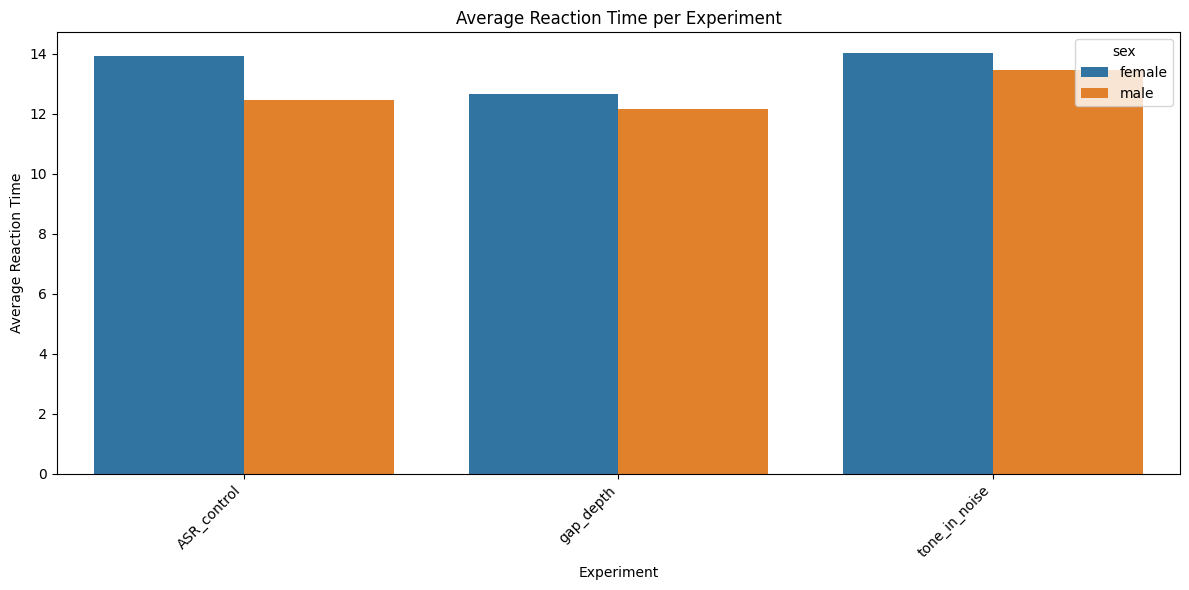

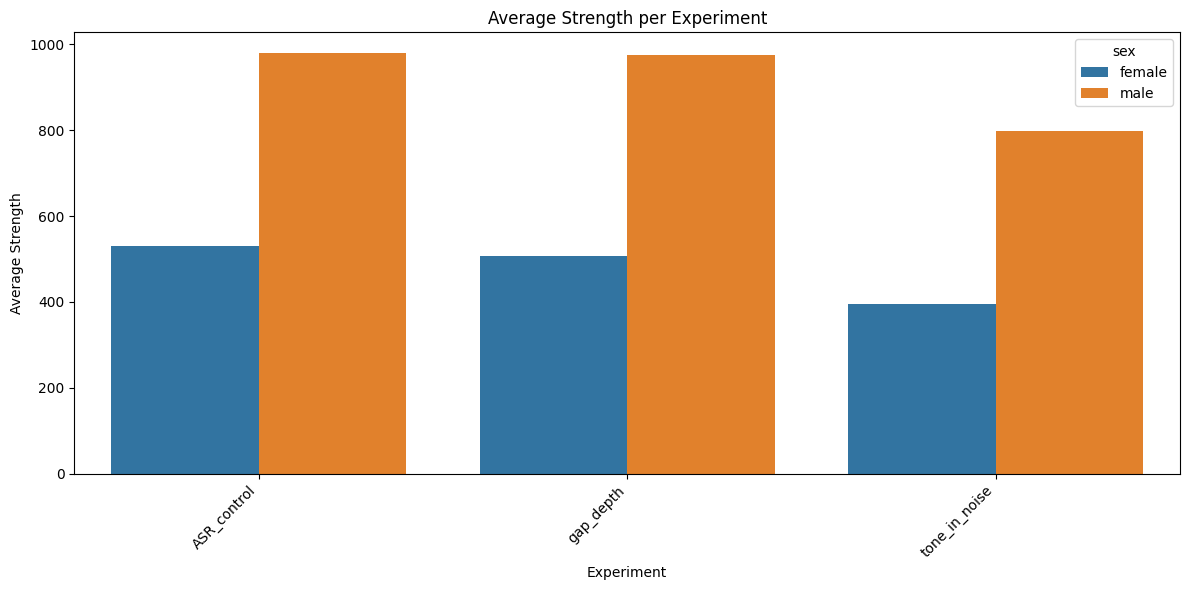

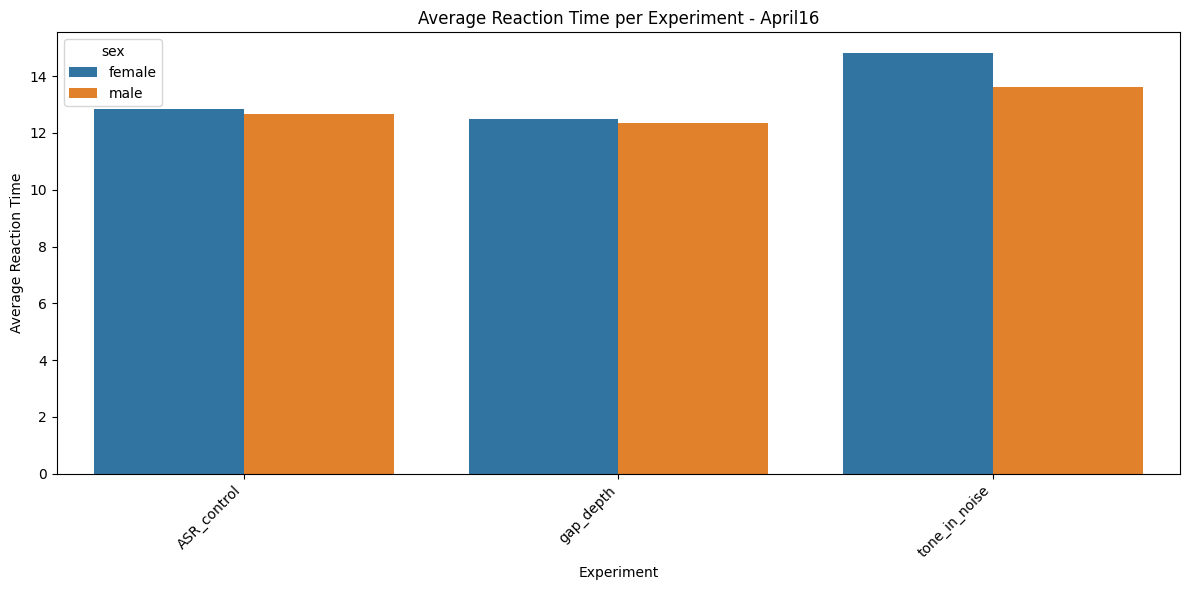

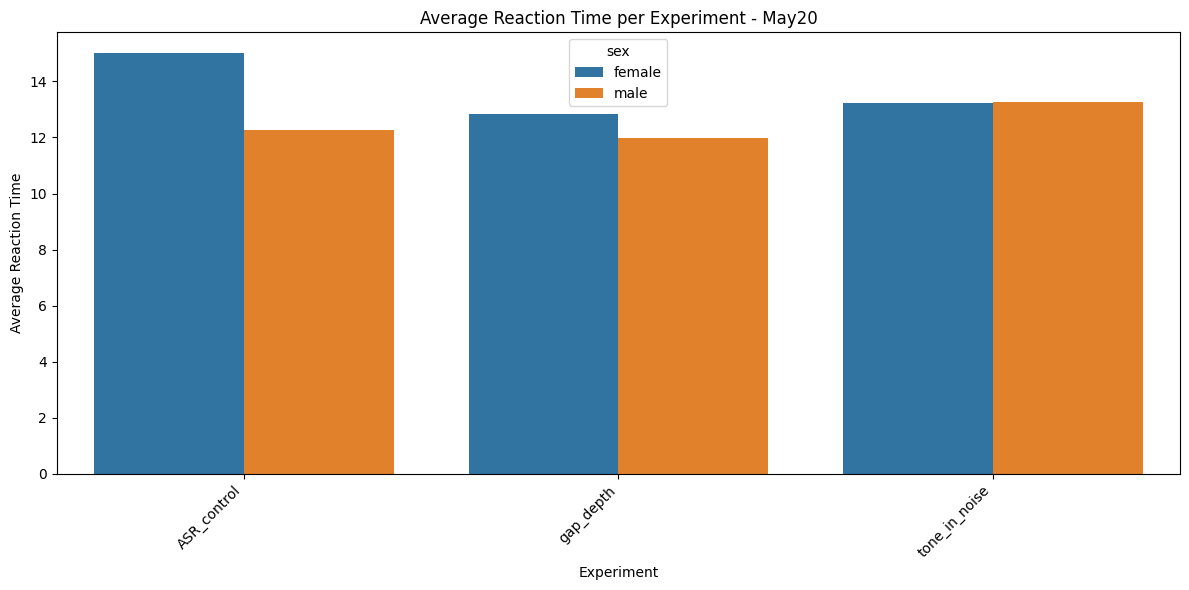

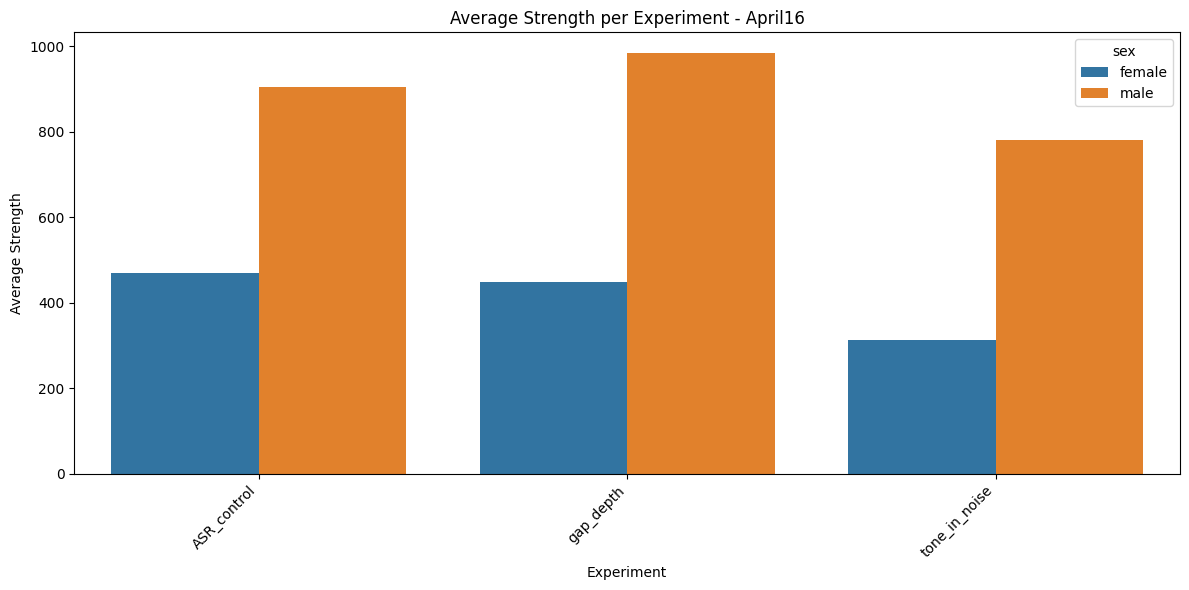

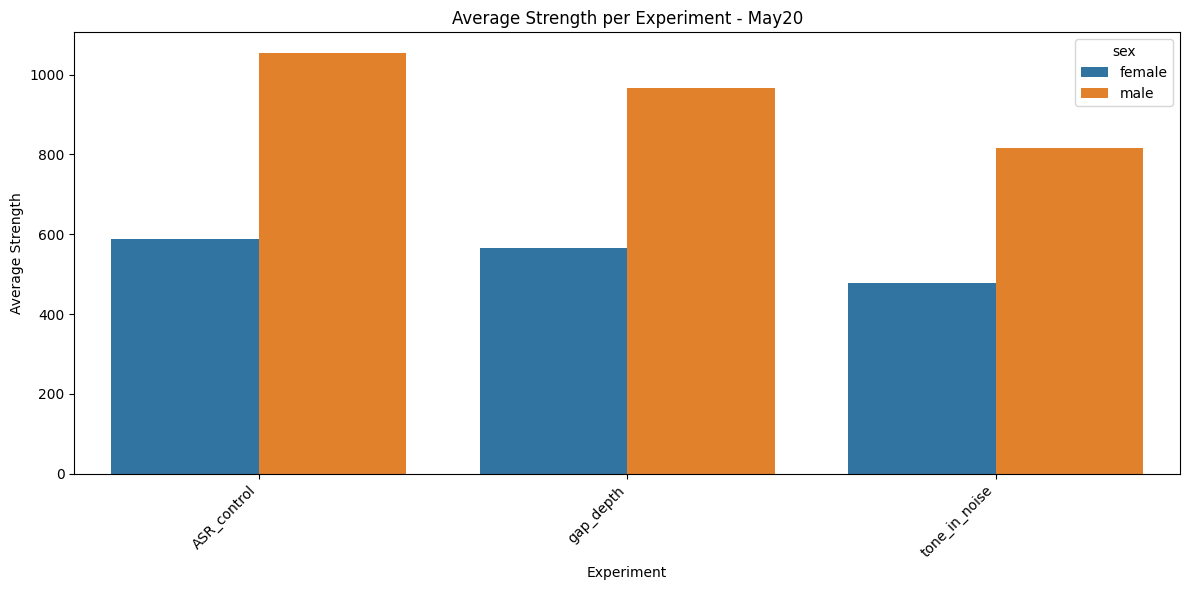

Top 10:


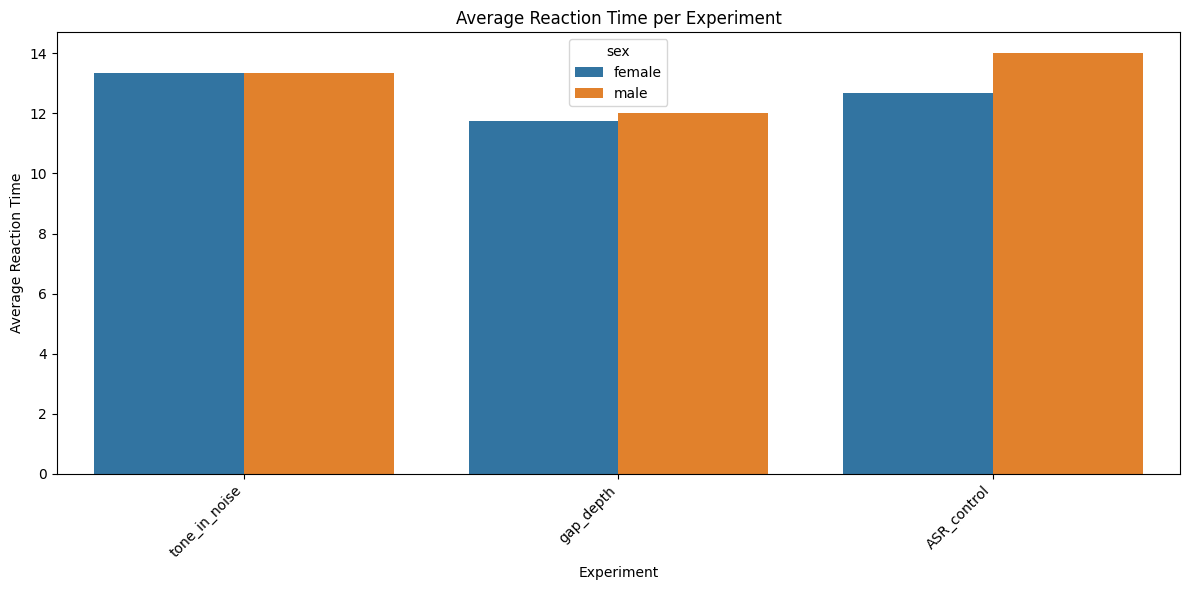

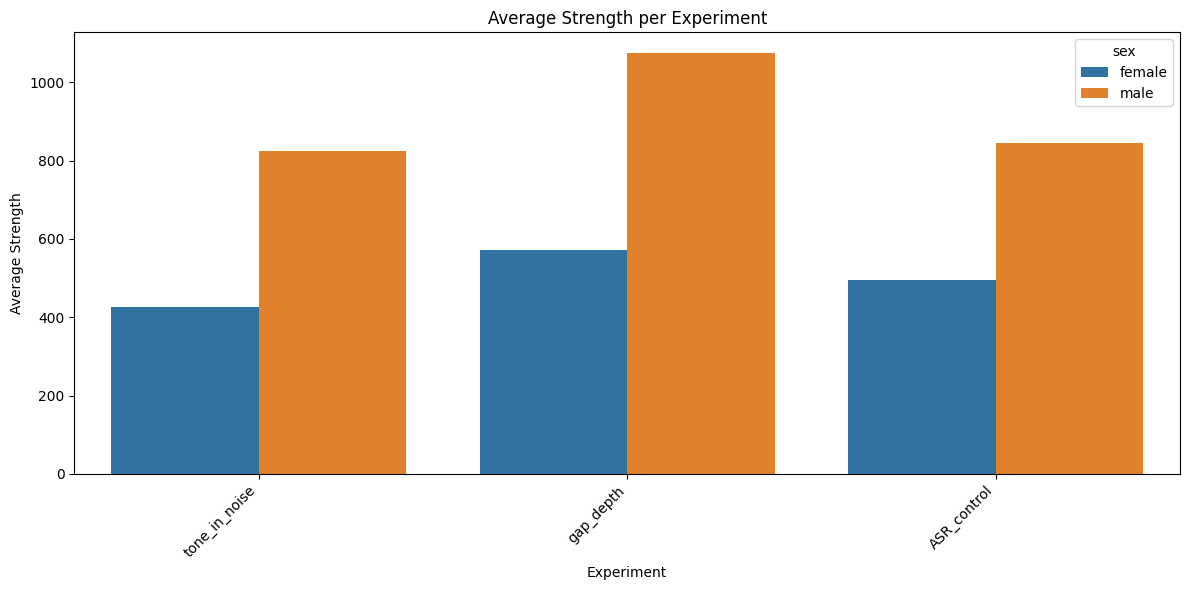

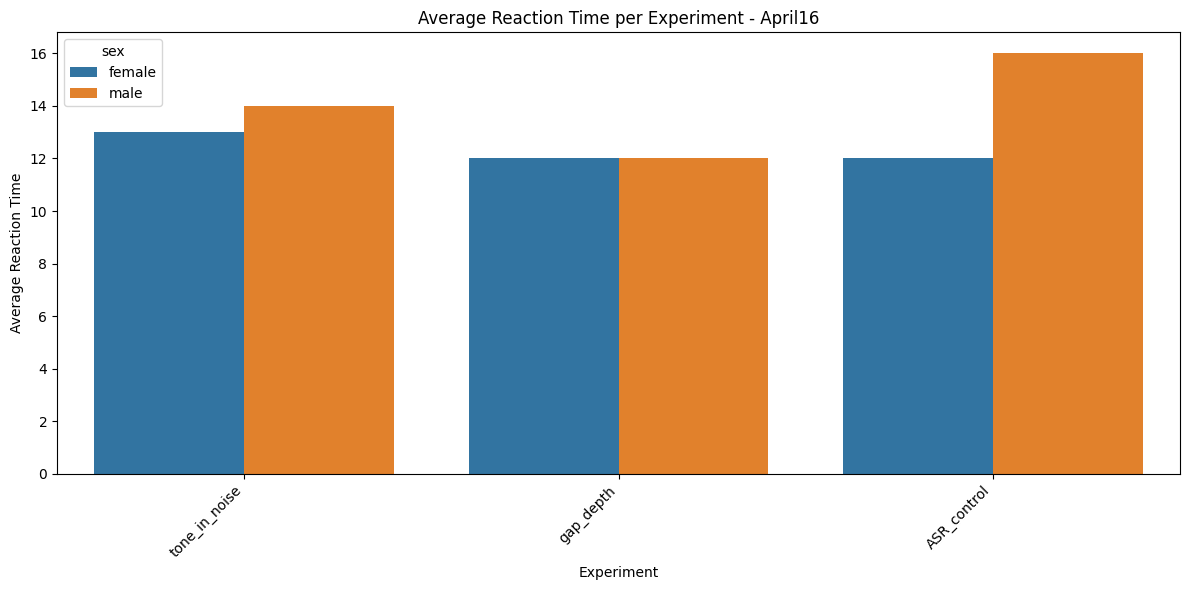

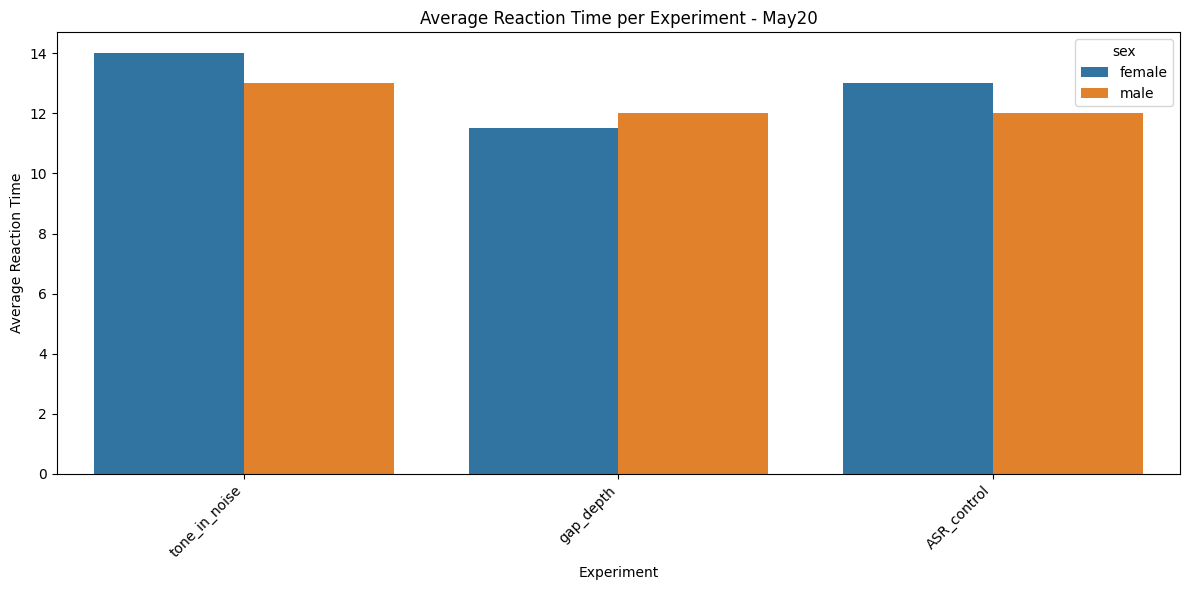

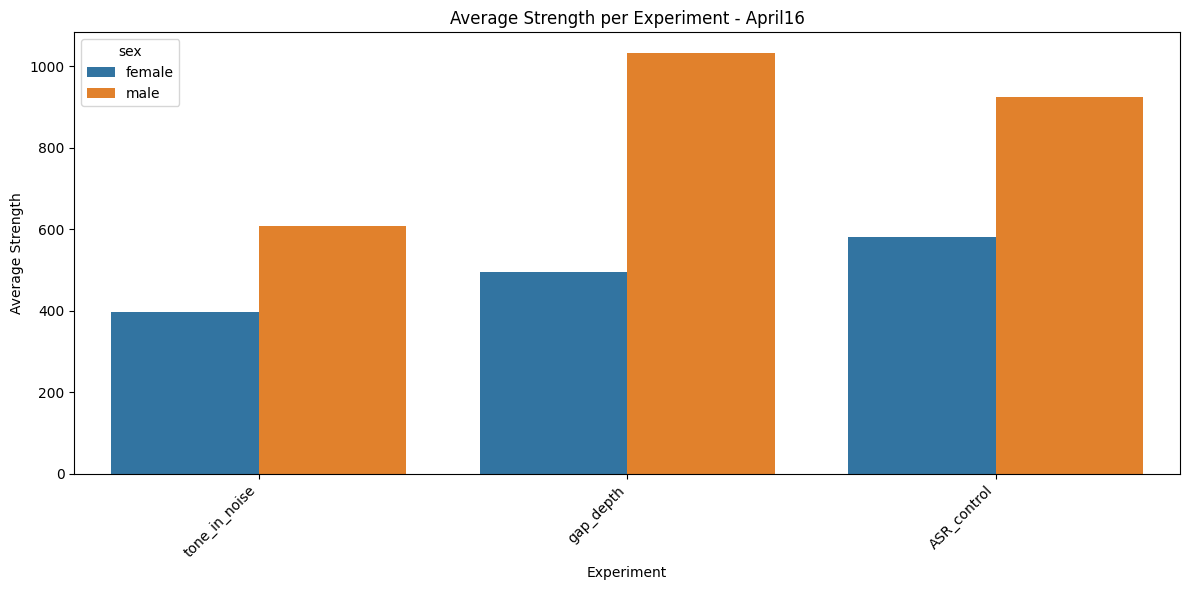

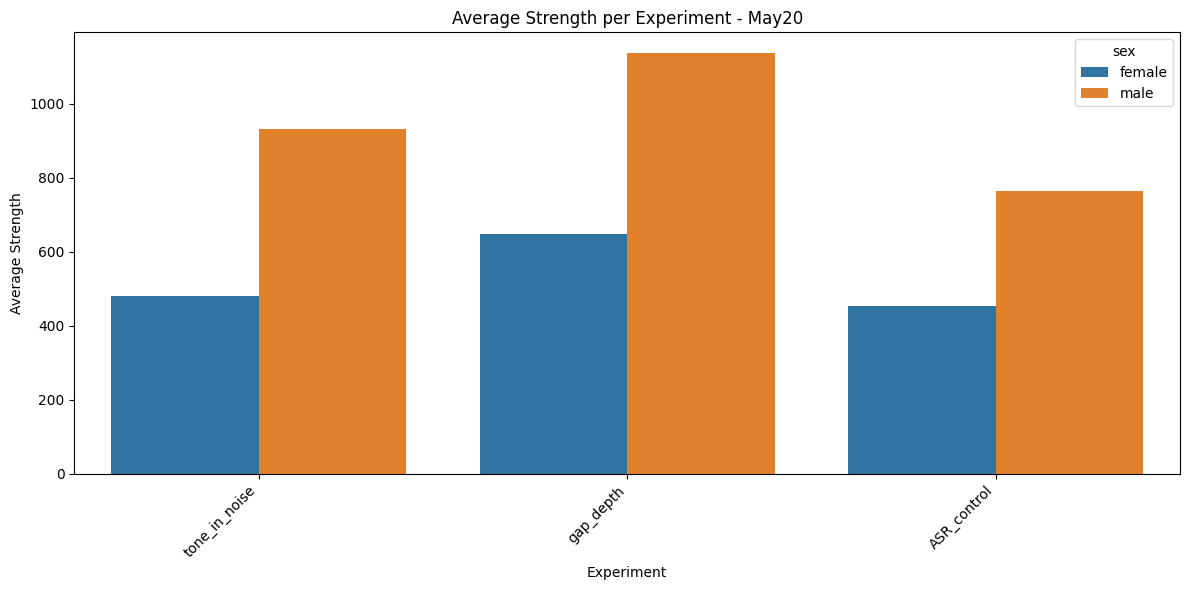

In [13]:
plot_results()
plot_results(strength=True)
plot_results(by_date=True)
plot_results(strength=True, by_date= True)

print("Top 10:")
plot_results(df=df_top_10)
plot_results(df=df_top_10, strength=True)
plot_results(df=df_top_10, by_date=True)
plot_results(df=df_top_10, strength=True, by_date= True)